In [ ]:
!pip install opencv-python opencv-python-headless numpy

Image 1:


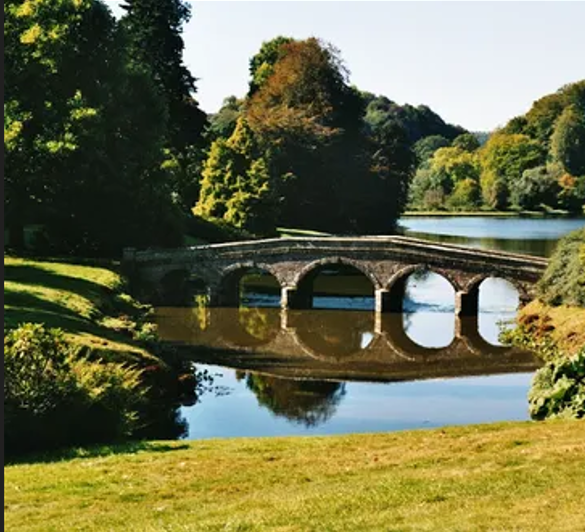

Image 2:


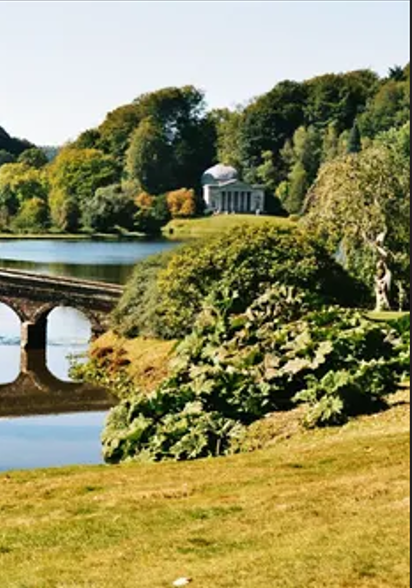

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Read the images
img1 = cv2.imread('/content/img1.png')
img2 = cv2.imread('/content/img2.png')



# Display the images
print("Image 1:")
cv2_imshow(img1)

print("Image 2:")
cv2_imshow(img2)


Stitched Image:


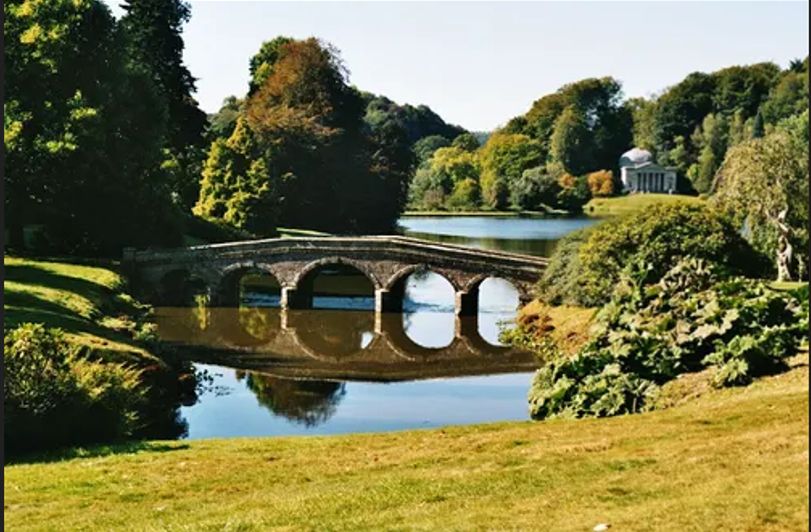

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the images
img1 = cv2.imread('/content/img1.png')  # left
img2 = cv2.imread('/content/img2.png')  # right

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Use SIFT detector (works better than ORB in many cases)
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Create FLANN matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Proceed only if we have enough good matches
if len(good_matches) > 10:
    # Get the matching keypoints' coordinates
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute homography matrix
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Warp img2 to align with img1
    height, width = img1.shape[:2]
    warped_img2 = cv2.warpPerspective(img2, H, (width * 2, height))

    # Place img1 into the stitched canvas
    stitched = warped_img2.copy()
    stitched[0:height, 0:width] = img1

    # Optional: Crop out black borders
    gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    stitched_cropped = stitched[y:y+h, x:x+w]

    # Show result
    print("Stitched Image:")
    cv2_imshow(stitched_cropped)
else:
    print("Not enough good matches were found - try different images or tune parameters.")


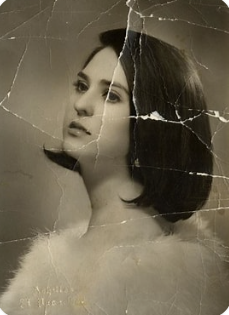

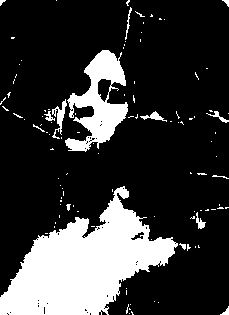

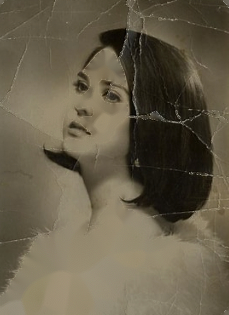

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Step 1: Load the damaged image
img = cv2.imread('/content/damaged1.png')
cv2_imshow(img)

# Step 2: Convert to grayscale to create a mask for damaged areas
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 3: Create binary mask of the white damage (tweak threshold if needed)
_, mask = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY)
cv2_imshow(mask)

# Step 4: Inpaint using Telea's algorithm
inpainted = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
cv2_imshow(inpainted)


Image Pair 1↔2 Matches:


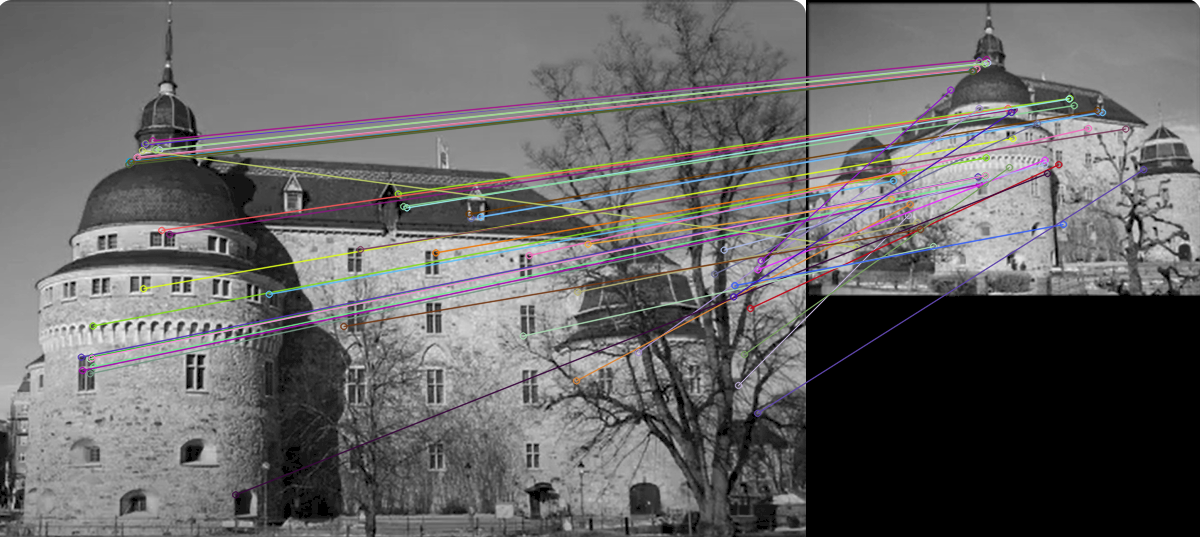

Rotation (R) for pair 1-2:
 [[ 0.40173465 -0.14907542 -0.9035407 ]
 [-0.12787723  0.96786143 -0.21654482]
 [ 0.9067837   0.20253584  0.36976012]]
Translation (t) for pair 1-2:
 [[ 0.27913468]
 [-0.05185689]
 [ 0.95885071]]

Image Pair 2↔3 Matches:


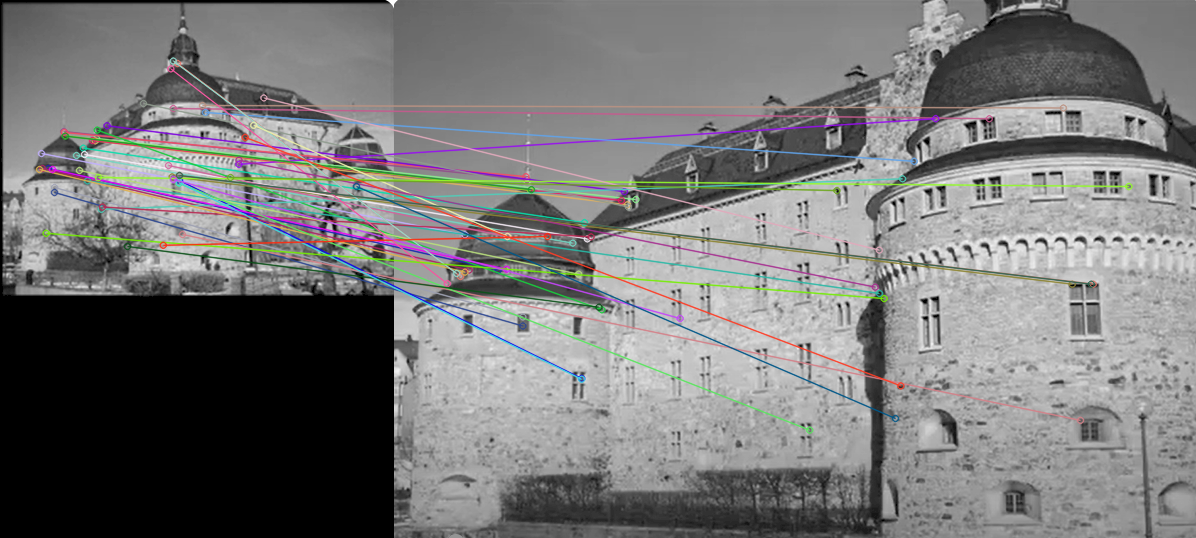

Rotation (R) for pair 2-3:
 [[-0.51695408  0.19565169 -0.833354  ]
 [ 0.08789746  0.9805161   0.17567646]
 [ 0.85148841  0.01756697 -0.52407908]]
Translation (t) for pair 2-3:
 [[ 0.4213493 ]
 [-0.03508684]
 [ 0.90621944]]

Image Pair 3↔4 Matches:


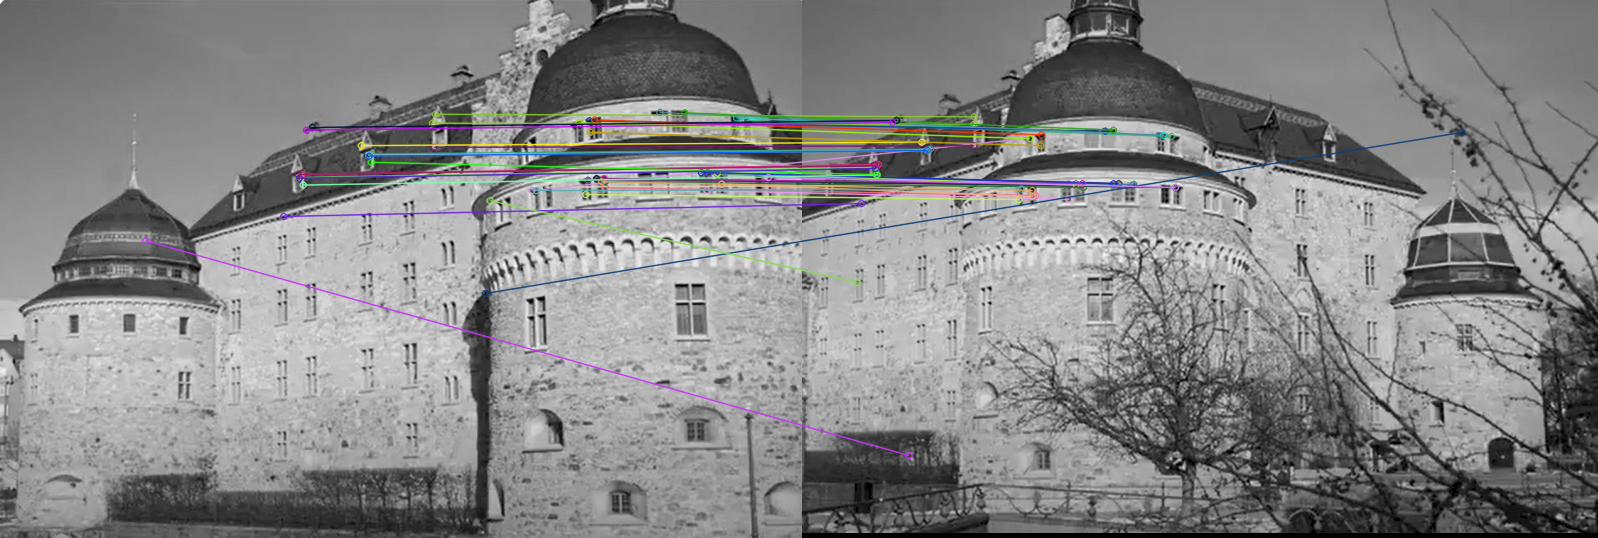

Rotation (R) for pair 3-4:
 [[ 0.98785505  0.09156275 -0.12553354]
 [ 0.00649411  0.78288561  0.62213178]
 [ 0.1552425  -0.61539125  0.77278288]]
Translation (t) for pair 3-4:
 [[-0.2390045 ]
 [-0.75115362]
 [ 0.61534144]]

--- Global Camera Poses ---
Image 1:
R =
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
t =
[0. 0. 0.]

Image 2:
R =
[[ 0.40173465 -0.14907542 -0.9035407 ]
 [-0.12787723  0.96786143 -0.21654482]
 [ 0.9067837   0.20253584  0.36976012]]
t =
[ 0.27913468 -0.05185689  0.95885071]

Image 3:
R =
[[-0.98836959  0.09764482  0.11658061]
 [ 0.06922633  0.97148115 -0.22678646]
 [-0.13540039 -0.21607839 -0.96694202]]
t =
[-0.53215848  0.10704937  0.64047482]

Image 4:
R =
[[-0.95303005  0.2125355   0.21578321]
 [-0.03645918  0.62676349 -0.77835613]
 [-0.30067334 -0.74966405 -0.58957557]]
t =
[-0.83529927 -0.27234236  0.96179856]



In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load 4 grayscale images
imgs = [cv2.imread(f'/content/sfm{i}.png', cv2.IMREAD_GRAYSCALE) for i in range(1, 5)]

# Camera intrinsics (example values — replace with calibration data if available)
h, w = imgs[0].shape
K = np.array([[1000, 0, w/2],
              [0, 1000, h/2],
              [0, 0, 1]])

# ORB detector
orb = cv2.ORB_create(10000)
poses = [(np.eye(3), np.zeros((3, 1)))]  # Initial pose: Identity R, zero t

for i in range(len(imgs)-1):
    img1, img2 = imgs[i], imgs[i+1]

    # Feature detection
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Matching
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw matches (optional)
    img_match = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)
    print(f"\nImage Pair {i+1}↔{i+2} Matches:")
    cv2_imshow(img_match)

    # Extract matched points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Fundamental matrix
    F, mask_f = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 0.5, 0.99)
    pts1 = pts1[mask_f.ravel() == 1]
    pts2 = pts2[mask_f.ravel() == 1]

    # Essential matrix
    E, mask_e = cv2.findEssentialMat(pts1, pts2, K, cv2.RANSAC, 0.999, 0.5)

    # Recover pose
    _, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)
    poses.append((R, t))

    print(f"Rotation (R) for pair {i+1}-{i+2}:\n", R)
    print(f"Translation (t) for pair {i+1}-{i+2}:\n", t)

# Pose chaining (optional: compute cumulative pose relative to the first image)
global_poses = [poses[0]]
for i in range(1, len(poses)):
    R_prev, t_prev = global_poses[-1]
    R_curr, t_curr = poses[i]
    R_global = R_curr @ R_prev
    t_global = R_curr @ t_prev + t_curr
    global_poses.append((R_global, t_global))

# Print global poses
print("\n--- Global Camera Poses ---")
for i, (R, t) in enumerate(global_poses):
    print(f"Image {i+1}:\nR =\n{R}\nt =\n{t.ravel()}\n")


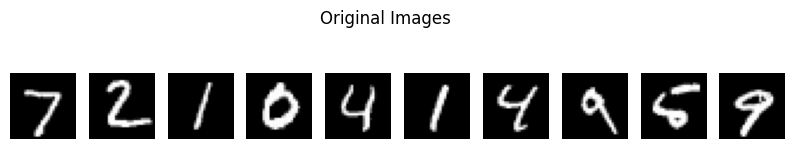

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load MNIST
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and reshape
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Show original images
plt.figure(figsize=(10, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Original Images")
plt.show()


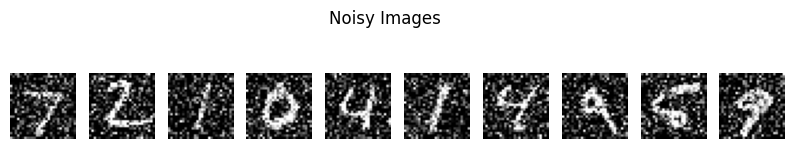

In [ ]:
# Add Gaussian noise
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Show noisy images
plt.figure(figsize=(10, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Noisy Images")
plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.2308 - val_loss: 0.1037
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1023 - val_loss: 0.0960
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0960 - val_loss: 0.0932
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0933 - val_loss: 0.0914
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0917 - val_loss: 0.0905
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0907 - val_loss: 0.0898
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0898 - val_loss: 0.0886
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0891 - val_loss: 0.0881
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0885 - val_loss: 0.0879
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0882 - val_loss: 0.0873


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


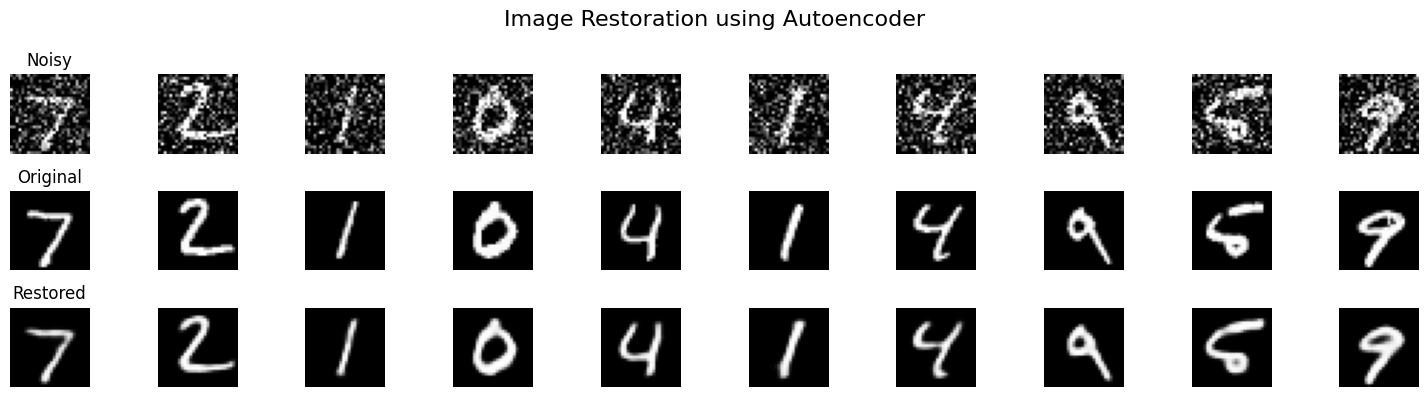

In [ ]:
# Get predictions
decoded_imgs = autoencoder.predict(x_test_noisy)

# Compare original, noisy, and restored
n = 10
plt.figure(figsize=(15, 4))
for i in range(n):
    # Noisy
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0: ax.set_title("Noisy")

    # Original
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0: ax.set_title("Original")

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0: ax.set_title("Restored")

plt.suptitle("Image Restoration using Autoencoder", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

# Example: compute PSNR for the test set
psnr_values = tf.image.psnr(decoded_imgs, x_test, max_val=1.0)

# Average PSNR
average_psnr = tf.reduce_mean(psnr_values).numpy()
print("Average PSNR on test data:", average_psnr, "dB")


Average PSNR on test data: 21.133404 dB


100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


MNIST (TensorFlow) Epoch [1/50] G_loss: 3.7420, D_loss: 0.0644
MNIST (TensorFlow) Epoch [2/50] G_loss: 3.4224, D_loss: 0.0811
MNIST (TensorFlow) Epoch [3/50] G_loss: 4.0978, D_loss: 0.3512
MNIST (TensorFlow) Epoch [4/50] G_loss: 5.0822, D_loss: 0.1775
MNIST (TensorFlow) Epoch [5/50] G_loss: 2.9150, D_loss: 1.4937
MNIST (TensorFlow) Epoch [6/50] G_loss: 1.5268, D_loss: 0.9948
MNIST (TensorFlow) Epoch [7/50] G_loss: 1.0096, D_loss: 2.4423
MNIST (TensorFlow) Epoch [8/50] G_loss: 3.6632, D_loss: 1.1457
MNIST (TensorFlow) Epoch [9/50] G_loss: 1.8414, D_loss: 0.8635
MNIST (TensorFlow) Epoch [10/50] G_loss: 0.5697, D_loss: 1.9136
MNIST (TensorFlow) Epoch [11/50] G_loss: 1.1151, D_loss: 1.3842
MNIST (TensorFlow) Epoch [12/50] G_loss: 2.6546, D_loss: 0.8263
MNIST (TensorFlow) Epoch [13/50] G_loss: 1.7580, D_loss: 1.2309
MNIST (TensorFlow) Epoch [14/50] G_loss: 1.2634, D_loss: 0.9754
MNIST (TensorFlow) Epoch [15/50] G_loss: 0.7690, D_loss: 1.8095
MNIST (TensorFlow) Epoch [16/50] G_loss: 1.0252, 

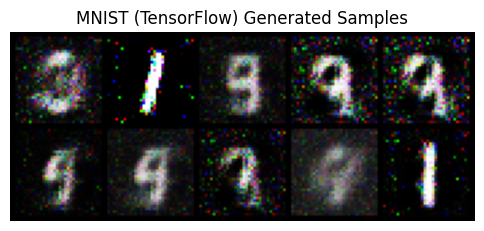

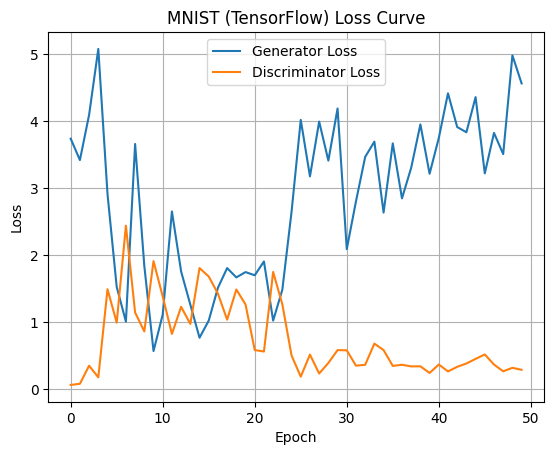

CIFAR-10 Epoch [1/50] G_loss: 0.9387, D_loss: 0.6079
CIFAR-10 Epoch [2/50] G_loss: 5.7929, D_loss: 0.0574
CIFAR-10 Epoch [3/50] G_loss: 6.4389, D_loss: 0.0980
CIFAR-10 Epoch [4/50] G_loss: 2.7434, D_loss: 0.1934
CIFAR-10 Epoch [5/50] G_loss: 3.8488, D_loss: 0.0623
CIFAR-10 Epoch [6/50] G_loss: 4.4998, D_loss: 0.0601
CIFAR-10 Epoch [7/50] G_loss: 4.8408, D_loss: 0.0656
CIFAR-10 Epoch [8/50] G_loss: 4.0748, D_loss: 0.0883
CIFAR-10 Epoch [9/50] G_loss: 4.6285, D_loss: 0.0385
CIFAR-10 Epoch [10/50] G_loss: 6.0073, D_loss: 0.0781
CIFAR-10 Epoch [11/50] G_loss: 4.9816, D_loss: 0.1586
CIFAR-10 Epoch [12/50] G_loss: 4.1413, D_loss: 0.1276
CIFAR-10 Epoch [13/50] G_loss: 5.1328, D_loss: 0.1203
CIFAR-10 Epoch [14/50] G_loss: 4.7440, D_loss: 0.0934
CIFAR-10 Epoch [15/50] G_loss: 5.4911, D_loss: 0.1261
CIFAR-10 Epoch [16/50] G_loss: 4.4572, D_loss: 0.2339
CIFAR-10 Epoch [17/50] G_loss: 4.4631, D_loss: 0.2108
CIFAR-10 Epoch [18/50] G_loss: 6.3615, D_loss: 0.1692
CIFAR-10 Epoch [19/50] G_loss: 4.3893

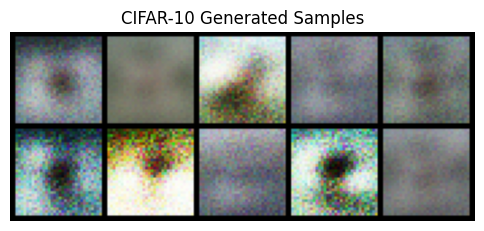

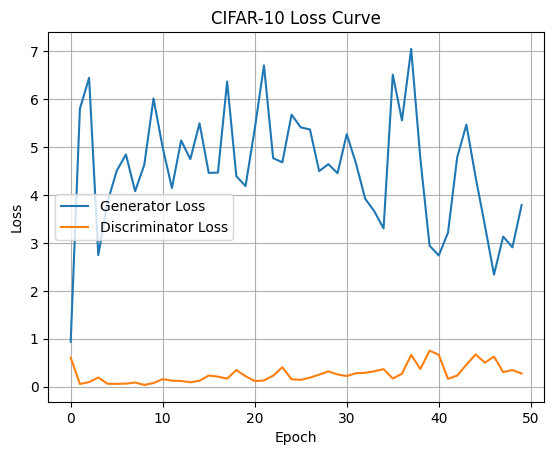

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tensorflow.keras.datasets import mnist as tf_mnist
import numpy as np
import matplotlib.pyplot as plt

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
epochs = 50
batch_size = 128

# CIFAR-10 Transform
transform_cifar = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10
cifar = datasets.CIFAR10(root='./data', train=True, transform=transform_cifar, download=True)
cifar_loader = torch.utils.data.DataLoader(cifar, batch_size=batch_size, shuffle=True)

# Load MNIST using TensorFlow, convert to RGB, resize
(train_images, _), _ = tf_mnist.load_data()
train_images = np.expand_dims(train_images, axis=1)  # (N, 1, 28, 28)
train_images = torch.tensor(train_images, dtype=torch.float32) / 127.5 - 1.0  # Normalize to [-1, 1]
train_images = torch.nn.functional.interpolate(train_images, size=32)  # Resize to 32x32
train_images = train_images.repeat(1, 3, 1, 1)  # Convert grayscale to 3 channels
mnist_loader = torch.utils.data.DataLoader(train_images, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 32 * 32 * 3),
            nn.Tanh()
        )
    def forward(self, z):
        return self.gen(z).view(-1, 3, 32, 32)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.dis = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.dis(x)

# GAN training function
def train_gan(dataloader, label):
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    loss_fn = nn.BCELoss()
    opt_G = optim.Adam(generator.parameters(), lr=2e-4)
    opt_D = optim.Adam(discriminator.parameters(), lr=2e-4)
    g_loss_hist, d_loss_hist = [], []

    for epoch in range(epochs):
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                x = batch[0]
            else:
                x = batch
            x = x.to(device)
            batch_size = x.size(0)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            z = torch.randn(batch_size, latent_dim).to(device)
            fake = generator(z)

            # Discriminator
            d_real = discriminator(x)
            d_fake = discriminator(fake.detach())
            d_loss = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)
            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

            # Generator
            d_fake = discriminator(fake)
            g_loss = loss_fn(d_fake, real_labels)
            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

        g_loss_hist.append(g_loss.item())
        d_loss_hist.append(d_loss.item())
        print(f'{label} Epoch [{epoch+1}/{epochs}] G_loss: {g_loss.item():.4f}, D_loss: {d_loss.item():.4f}')

    # Generate and display 10 fake images
    z = torch.randn(10, latent_dim).to(device)
    fake_images = generator(z).detach().cpu()
    grid = make_grid(fake_images, nrow=5, normalize=True)
    plt.figure(figsize=(6, 6))
    plt.title(f'{label} Generated Samples')
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

    # Plot loss curves
    plt.figure()
    plt.plot(g_loss_hist, label='Generator Loss')
    plt.plot(d_loss_hist, label='Discriminator Loss')
    plt.title(f'{label} Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train on MNIST
train_gan(mnist_loader, "MNIST (TensorFlow)")

# Train on CIFAR-10
train_gan(cifar_loader, "CIFAR-10")
